In [164]:
import math
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mediapipe as mp
from PIL import Image
import os
from tqdm import tqdm

In [165]:
def euclidean_distance(a, b):
    x1 = a[0]
    y1 = a[1]
    x2 = b[0]
    y2 = b[1]
    
    return math.sqrt((x2 - x1) * (x2 - x1) + (y2 - y1)* (y2 - y1))

In [168]:
def image_preprocessing(path):
    image = cv2.imread(path)
    
    if(type(image) == type(None)):
        #print("Cannot preprocess. image is None.")
        return
    
    # resize (48, 48) -> (224, 224)
    resized_image = resize(image)
    # normalize
    normalized_image = normalize(resized_image)
    # face rotation with extracting roi 
    roi_image = rotation_roi(normalized_image)
    # resize roi.shape -> -> (224, 224)
    resized_roi = resize(roi_image) 
    # apply face mesh
    result = draw_face_landmarks(resized_roi)
    
    return result

In [169]:
def resize(image):
    if(type(image) == type(None)):
        #print("Cannot preprocess. image is None.")
        return
    
    #print("In resize(), type(image)=", type(image))
    image = image.astype(np.uint8)
    resized_image = cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_LINEAR)
    return resized_image

In [170]:
def normalize(image):
    if(type(image) == type(None)):
        #print("Cannot normalize. image is None.")
        return
    
    result = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
    # print(type(result))
    return result

In [171]:
def rotation_roi(image):
    if(type(image) == type(None)):
        #print("Cannot rotation. image is None.")
        return None, None
    
    # the position number of silhoueets
    silhouette = [
        10,  338, 297, 332, 284, 251, 389, 356, 454, 323, 361, 288,
        397, 365, 379, 378, 400, 377, 152, 148, 176, 149, 150, 136,
        172, 58,  132, 93,  234, 127, 162, 21,  54,  103, 67,  109]
    
    # for ROI
    x, y = 0, 0
    minX, minY = 1000, 1000 
    maxX, maxY = 0, 0
    roi_t = 10
    
    # for face mesh style
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    mp_face_mesh = mp.solutions.face_mesh
    
    # For static images:
    drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
    
    with mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        refine_landmarks=True,
        min_detection_confidence=0.5) as face_mesh:
        
        width = image.shape[1]
        height = image.shape[0]
        new_image = image.copy()
        
        # Convert the BGR image to RGB before processing.
        results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        
        # Print and draw face mesh landmarks on the image.
        if not results.multi_face_landmarks:
              return None
            
        annotated_image = image.copy()

        for face_landmarks in results.multi_face_landmarks:
            ### rotation
            irises = list(mp_face_mesh.FACEMESH_IRISES)
                
            # left eye 눈동자 상하 위치 인덱스: 0, 1 
            l_pt1_x = int(face_landmarks.landmark[irises[0][0]].x * width)
            l_pt1_y = int(face_landmarks.landmark[irises[0][0]].y * height)
            l_pt2_x = int(face_landmarks.landmark[irises[1][0]].x * width)
            l_pt2_y = int(face_landmarks.landmark[irises[1][0]].y * height)
            # right eye 눈동자 상하 위치 인덱스: 3, 6
            r_pt1_x = int(face_landmarks.landmark[irises[7][0]].x * width)
            r_pt1_y = int(face_landmarks.landmark[irises[7][0]].y * height)
            r_pt2_x = int(face_landmarks.landmark[irises[3][0]].x * width)
            r_pt2_y = int(face_landmarks.landmark[irises[3][0]].y * height)

            # left eye
            if l_pt1_x > l_pt2_x:
                left_eye_x = l_pt2_x + (l_pt1_x - l_pt2_x) // 2
            else:
                left_eye_x = l_pt1_x + (l_pt2_x - l_pt1_x) // 2

            left_eye_y = l_pt1_y + (l_pt2_y - l_pt1_y) // 2

            # right eye
            if r_pt1_x > r_pt2_x:
                right_eye_x = r_pt2_x + (r_pt1_x - r_pt2_x) // 2
            else:
                right_eye_x = r_pt1_x + (r_pt2_x - r_pt1_x) // 2

            right_eye_y = r_pt1_y + (r_pt2_y - r_pt1_y) // 2

            left_eye_center = (left_eye_x, left_eye_y)
            right_eye_center = (right_eye_x, right_eye_y)
            
            if left_eye_y < right_eye_y :
                point_3rd = (right_eye_x, left_eye_y)
                direction = 1 # 반시계방향
                # print("반시계방향 회전")
            else:
                point_3rd = (left_eye_x, right_eye_y)
                direction = -1 # 시계방향
                # print("시계방향 회전")

            a = euclidean_distance(left_eye_center, point_3rd)
            b = euclidean_distance(right_eye_center, left_eye_center)
            c = euclidean_distance(right_eye_center, point_3rd)

            cos_a = (b * b + c * c - a * a) / (2 * b * c)
            # print("cos(a) = ", cos_a)

            angle = np.arccos(cos_a)
            # print("angle : " , angle, " in radian")

            angle = (angle * 180) / math.pi
            # print("angle : ", angle, " in degree")

            if direction == 1:
                angle = 90 - angle

        rotated_image = Image.fromarray(annotated_image)
        rotated_image = np.array(rotated_image.rotate(direction * (-1) * angle))
    
    roi_image = roi(face_landmarks, rotated_image)
    
    return roi_image

In [172]:
def roi(face_landmarks, image):
    if(type(image) == type(None)):
        #print("Cannot extract roi. ")
        return _, None
    
     # the position number of silhoueets
    silhouette = [
        10,  338, 297, 332, 284, 251, 389, 356, 454, 323, 361, 288,
        397, 365, 379, 378, 400, 377, 152, 148, 176, 149, 150, 136,
        172, 58,  132, 93,  234, 127, 162, 21,  54,  103, 67,  109]
    
    # for ROI
    x, y = 0, 0
    minX, minY = 1000, 1000 
    maxX, maxY = 0, 0
    roi_t = 10
    
    height = image.shape[0]
    width = image.shape[1]
    
    for i in silhouette:
        # find silhouette
        x = int(face_landmarks.landmark[i].x * image.shape[1])
        y = int(face_landmarks.landmark[i].y * image.shape[0])
        
        # find ROI coordinate
        if x < minX:
            minX = x
        if y < minY:
            minY = y
        if x > maxX:
            maxX = x
        if y > maxY:
            maxY = y

    # adjust the points (x1, y1), (x2, y2)
    x1 = minX - roi_t
    y1 = minY - roi_t
    x2 = maxX + roi_t + 1
    y2 = maxY + roi_t + 1

    if(x1 < 0):
        x1 = 0
    if(y1 < 0):
        y1 = 0
    if(x2 > width or x2 < 0):
        x2 = width
    if(y2 > height or y2 < 0):
        y2 = height

    # extract roi
    #print(x1, x2, y1, y2)
    roi_image = image[y1:y2, x1:x2]

    return roi_image

In [173]:
def reduced_face_mesh(image):
    if(type(image) == type(None)):
        #print("Cannot face mesh. image is None.")
        return
    
    # for face mesh style
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    mp_face_mesh = mp.solutions.face_mesh
    
    # For static images:
    drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
    
    height = image.shape[0]
    width = image.shape[1]
  
    landmarks = list(mp_face_mesh.FACEMESH_CONTOURS)
    
    with mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        refine_landmarks=True,
        min_detection_confidence=0.5) as face_mesh:
        
        # Convert the BGR image to RGB before processing.
        results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        # Print and draw face mesh landmarks on the image.
        if not results.multi_face_landmarks:
            #print("Cannot find landmark on the image.")
            return
            
        annotated_image = image.copy()
        
        for face_landmarks in results.multi_face_landmarks:
            for i in range(len(landmarks)):
                x = int(face_landmarks.landmark[landmarks[i][0]].x * width)
                y = int(face_landmarks.landmark[landmarks[i][0]].y * height)
                
               # print(i)
                cv2.line(annotated_image, (x, y), (x, y), (255, 0, 0), 2)
            
    return annotated_image

In [174]:
def draw_face_landmarks(image):
    _RED = (48, 48, 255)
    _GREEN = (48, 255, 48)
    _BLUE = (192, 101, 21)
    _YELLOW = (0, 204, 255)
    _GRAY = (128, 128, 128)
    _PURPLE = (128, 64, 128)
    _PEACH = (180, 229, 255)
    _WHITE = (224, 224, 224)

    _THICKNESS_TESSELATION = 1
    _THICKNESS_CONTOURS = 1
    
    if(type(image) == type(None)):
        #print("Cannot face mesh. image is None.")
        return
    
    # for face mesh style
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    mp_face_mesh = mp.solutions.face_mesh
    
    # For static images:
    drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
    
    height = image.shape[0]
    width = image.shape[1]
  
    tesselation_landmarks = list(mp_face_mesh.FACEMESH_TESSELATION)
    contours_landmarks = list(mp_face_mesh.FACEMESH_CONTOURS)
    
    with mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        refine_landmarks=True,
        min_detection_confidence=0.5) as face_mesh:
        
        # Convert the BGR image to RGB before processing.
        results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        # Print and draw face mesh landmarks on the image.
        if not results.multi_face_landmarks:
            #print("Cannot find landmark on the image.")
            return
            
        annotated_image = image.copy()
        
        for face_landmarks in results.multi_face_landmarks:
            # eyebrows
            mp_drawing.draw_landmarks(
              image=annotated_image,
              landmark_list=face_landmarks,
              connections=mp_face_mesh.FACEMESH_LEFT_EYEBROW,
              landmark_drawing_spec=None,
              connection_drawing_spec=mp_drawing.DrawingSpec(color=_RED, thickness=_THICKNESS_CONTOURS))
    
            mp_drawing.draw_landmarks(
              image=annotated_image,
              landmark_list=face_landmarks,
              connections=mp_face_mesh.FACEMESH_RIGHT_EYEBROW,
              landmark_drawing_spec=None,
              connection_drawing_spec=mp_drawing.DrawingSpec(color=_RED, thickness=_THICKNESS_CONTOURS))
            # eyes
            mp_drawing.draw_landmarks(
              image=annotated_image,
              landmark_list=face_landmarks,
              connections=mp_face_mesh.FACEMESH_LEFT_EYE,
              landmark_drawing_spec=None,
              connection_drawing_spec=mp_drawing.DrawingSpec(color=_RED, thickness=_THICKNESS_CONTOURS))
            mp_drawing.draw_landmarks(
              image=annotated_image,
              landmark_list=face_landmarks,
              connections=mp_face_mesh.FACEMESH_RIGHT_EYE,
              landmark_drawing_spec=None,
              connection_drawing_spec=mp_drawing.DrawingSpec(color=_RED, thickness=_THICKNESS_CONTOURS))
            # lips
            mp_drawing.draw_landmarks(
              image=annotated_image,
              landmark_list=face_landmarks,
              connections=mp_face_mesh.FACEMESH_LIPS,
              landmark_drawing_spec=None,
              connection_drawing_spec=mp_drawing.DrawingSpec(color=_RED, thickness=_THICKNESS_CONTOURS))
            # face oval
            mp_drawing.draw_landmarks(
              image=annotated_image,
              landmark_list=face_landmarks,
              connections=mp_face_mesh.FACEMESH_FACE_OVAL,
              landmark_drawing_spec=None,
              connection_drawing_spec=mp_drawing.DrawingSpec(color=_RED, thickness=_THICKNESS_CONTOURS))
            # tesselation
            for i in range(len(tesselation_landmarks)):
                x = int(face_landmarks.landmark[tesselation_landmarks[i][0]].x * width)
                y = int(face_landmarks.landmark[tesselation_landmarks[i][0]].y * height)
                cv2.line(annotated_image, (x, y), (x, y), (255, 0, 0), 2)
            
    annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
    return annotated_image

In [178]:
path = '../../data/CK+48/anger/S010_004_00000017.png'
image = cv2.imread(path)

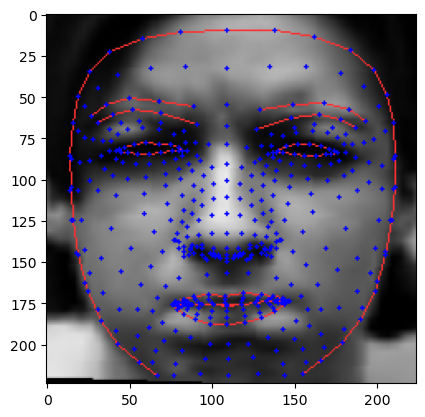

In [181]:
plt.imshow(image_preprocessing(path))

# Make dataset with landmark

In [205]:
os.chdir("..")

In [206]:
os.chdir("./Capstone_FER/preprocess")

In [207]:
os.getcwd()

'/Users/shimgahyeon/FER/Capstone_FER/preprocess'

In [208]:
os.chdir("../../data/CK+48")
classes = ["happy", "fear", "disgust", "anger", "sadness", "surprise", "contempt", "neutral"]
no_landmark = {}


for label in classes:
    print("##", label, "##")
    os.chdir("./"+label)
    
    files = sorted(os.listdir(os.getcwd()))
    print("Total count of images in {}: {}".format(label, len(files)))

    file_list = []
    none_file_count = 0

    for file in tqdm(files):
        result = image_preprocessing(file)
        
        if file == 'label.csv':
            continue
            
        if(type(result) == type(None)):
            file_list.append(file)
            none_file_count += 1
            
#         else:
#             cv2.imwrite("../../../CK+Landmark/"+mode+"/"+file, result)
            
    print("Total count of non images(cannot preprossed):", none_file_count)
    print("file list which cannot preprocess:")
    print(file_list)
    no_landmark[label] = file_list

    os.chdir("..")

os.chdir("..")

## happy ##
Total count of images in happy: 207


100%|█████████████████████████████████████████| 207/207 [00:16<00:00, 12.65it/s]


Total count of non images(cannot preprossed): 0
file list which cannot preprocess:
[]
## fear ##
Total count of images in fear: 75


100%|███████████████████████████████████████████| 75/75 [00:05<00:00, 12.60it/s]


Total count of non images(cannot preprossed): 0
file list which cannot preprocess:
[]
## disgust ##
Total count of images in disgust: 177


100%|█████████████████████████████████████████| 177/177 [00:14<00:00, 12.10it/s]

Total count of non images(cannot preprossed): 0
file list which cannot preprocess:
[]
## angry ##


FileNotFoundError: [Errno 2] No such file or directory: './angry'